In [1]:
using Random
Random.seed!(87613) # Set random seed

using LinearAlgebra
using PyPlot
using ForneyLab

include("environment.jl") # Include environmental dynamics
include("helpers.jl") # Include helper functions for plotting
;

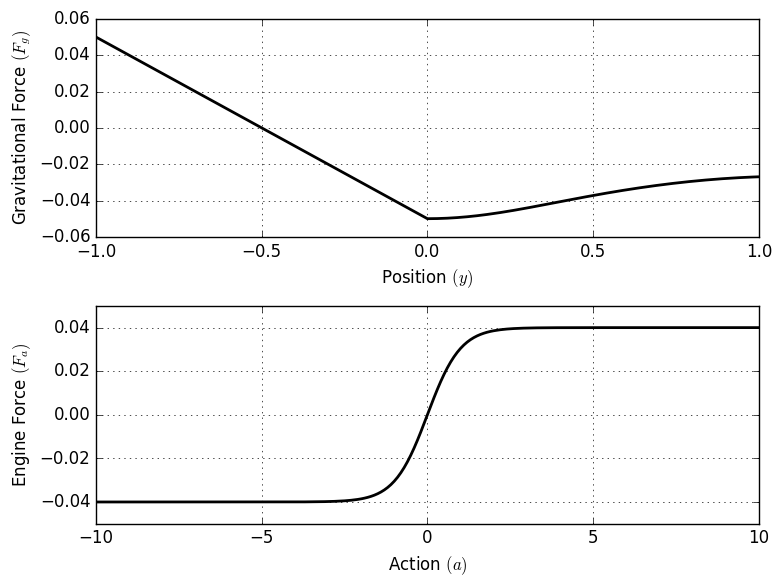

In [2]:
plotLandscape() # Visualize gravitational landscape end engine response
;

In [3]:
# Simulation for the naive policy of going full power up the right slope
T = 30 # Total simulation time

pi_naive = 100.0*ones(T) # Naive policy for right full-power only
(execute, observe) = initializeWorld() # Let there be a world

y_hat_naive = Vector{Vector{Float64}}(undef, T)
for t = 1:T
    execute(pi_naive[t]) # Execute environmental process
    y_hat_naive[t] = observe() # Observe external states
end
;

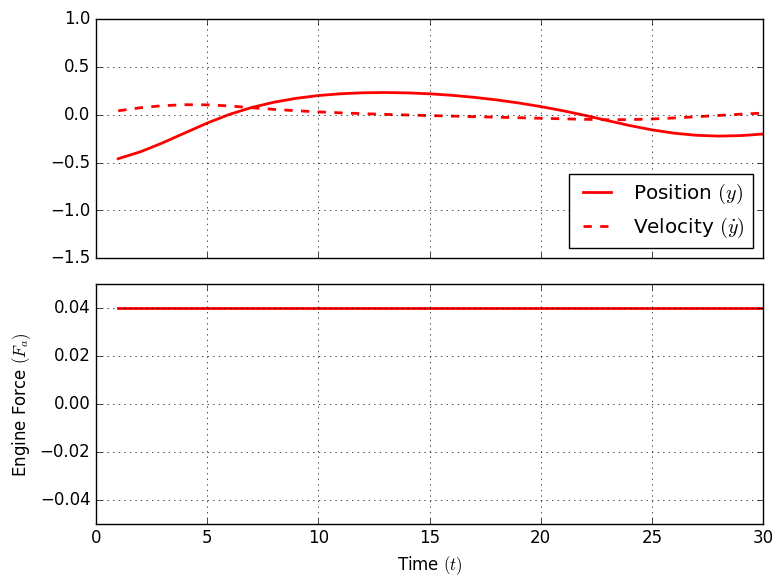

In [4]:
plotTrajectory(pi_naive, y_hat_naive, color="red")
;

In [5]:
include("agent.jl") # Load agent's (accurate) internal beliefs over external dynamics

# Internal model perameters
gamma = 1e4*diageye(2) # Transition precision
theta = 1e-4*diageye(2) # Observation variance
;

<img src="./figures/model.png">

In [6]:
# Build internal model
fg = FactorGraph()

x = Vector{Variable}(undef, T) # Observed states
s = Vector{Variable}(undef, T) # Brain states
u = Vector{Variable}(undef, T) # Control states

@RV [id=pad(:s, 0)] s_0 ~ GaussianMeanVariance([-0.5, 0.0], tiny*diageye(2)) # Initial brain state

s_t_min = s_0
for t=1:T
    @RV [id=pad(:u, t)]   u[t] ~ GaussianMeanVariance(placeholder(:m_u, var_id=:m_u_*t, index=t, dims=(1,)), 
                                                      placeholder(:V_u, var_id=:V_u_*t, index=t, dims=(1,1))) # Control prior
    @RV [id=pad(:u_h, t)] u_h_t ~ Nonlinear(u[t], h, Jh, h_inv, dims=(1,)) # Control model
    @RV [id=pad(:s_g, t)] s_g_t ~ Nonlinear(s_t_min, g, Jg, dims=(2,)) # Transition model for gravity and friction
    @RV [id=pad(:s, t)]   s[t] ~ GaussianMeanPrecision(s_g_t + u_h_t, gamma) # State transition model including control
    @RV [id=pad(:x, t)]   x[t] ~ GaussianMeanVariance(s[t], theta) # Observation model
    GaussianMeanVariance(x[t],
                         placeholder(:m_x, var_id=:m_x_*t, dims=(2,), index=t),
                         placeholder(:V_x, var_id=:V_x_*t, dims=(2,2), index=t)) # Goal prior
    s_t_min = s[t]
end
;

In [7]:
# Schedule message passing algorithm
algo = sumProductAlgorithm([s; u]) # Infer internal states
eval(Meta.parse("begin $algo end")) # This evaluation loads the step!() and init() functions for inference
;

In [8]:
(execute, observe)  = initializeWorld() # Let there be a world
(infer, act, slide) = initializeAgent() # Let there be an agent

# Step through experimental protocol
a = Vector{Float64}(undef, T) # Actions
y = Vector{Vector{Float64}}(undef, T) # Observations
for t=1:T
    a[t] = act(t) # Evoke an action from the agent
           execute(a[t]) # The action influences hidden external states
    y[t] = observe() # Observe the current environmental outcome (update p)
           infer(a[t], y[t], t) # Infer beliefs from current model state (update q)
           slide() # Prepare for next iteration
end
;

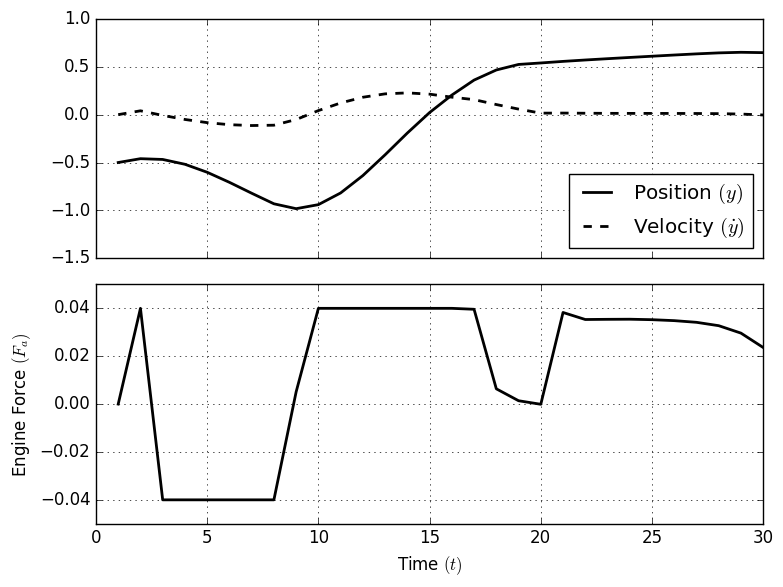

In [9]:
plotTrajectory(a, y)
;